In [1]:
#Libraries 
import pandas as pd 
import numpy as np 

# data visualization packages 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
pd.set_option('max_columns', None)

# SMOTE package to address imbalanced classes 
from imblearn.over_sampling import SMOTE 

# machine learning packages (sklearn + xgboost)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

# Feature Processing 

In [2]:
df = pd.read_csv('../data/cleaned_df.csv')
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,Diabetes,Missing,Missing,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,Endocrine/Metabolic/Immunity Disorder,Diabetes,Endocrine/Metabolic/Immunity Disorder,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,No
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,Complications of Pregnancy/Childbirth/Puerperium,Diabetes,External Injury/Supplemental,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,Infectious and Parasitic Disease,Diabetes,Circulatory Disease,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,No
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,No


In [3]:
df.shape

(71518, 45)

In [4]:
#Inspect Unknown/Invalid results
df[df['gender'].str.contains('Unknown/Invalid')]

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
22926,Other,Unknown/Invalid,[70-80),3,1,1,1,5,5,22,0,0,0,Circulatory Disease,Circulatory Disease,Circulatory Disease,4,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,No
55129,unknown,Unknown/Invalid,[60-70),1,1,7,1,38,1,6,0,0,0,Injury and Poisoning,Injury and Poisoning,External Injury/Supplemental,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
59490,unknown,Unknown/Invalid,[70-80),1,22,7,8,59,2,21,0,0,0,Injury and Poisoning,Injury and Poisoning,Injury and Poisoning,9,None,None,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,No


In [5]:
# Only 3 entries unknown so we will drop them 
df = df[df['gender']!='Unknown/Invalid']

In [6]:
#Check to make sure they are gone 
#df[df['gender'].str.contains('Unknown/Invalid')]

 If we look at the IDs_mapping.csv we can see that 11,13,14,19,20,21 are related to death or hospice. We should remove these samples from the predictive model. 

In [7]:
# remove expired or hospice-bound patients
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [8]:
#Transform nominal columns to string type
df.admission_type_id = df.admission_type_id.astype(str)
df.admission_source_id = df.admission_source_id.astype(str)
df.discharge_disposition_id = df.discharge_disposition_id.astype(str)

In [9]:
df.shape

(69970, 45)

In [10]:
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age'] = df.age.replace(age_id)

In [11]:
# # quanitify glucose measurement readings

# df['max_glu_serum'] = df['max_glu_serum'].map({'None':0, 'Norm':100, '>200':200, '>300':300})

In [12]:
# # quantify A1C measurement

# df['A1Cresult']= df.A1Cresult.map({'None':0,'Norm':3,'>7':7,'>8':8})

In [13]:
#Dropping medication with low usage 
df = df.drop(columns= ['examide','citoglipton'])

In [14]:
# quantify change in medications (test)

medication = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for med in medication:
    df[med] = df[med].map({'Up':1, 'Down':1, 'Steady':1, 'No':0})

In [15]:
# # encode change in medicine

# df['change'] = df['change'].map({'Ch':1,'No':0})

In [16]:
# encode whether patient is on medications

df['diabetesMed'] = df.diabetesMed.map({'Yes':1, 'No':0})

In [17]:
# encode output variable

df['readmitted'] = df.readmitted.map({'Yes':1, 'No':0})

### Test for prevalance of Readmission 

In [18]:
# shuffle the samples
df = df.sample(n = len(df), random_state = 123)
df = df.reset_index(drop = True)

In [19]:
# Save 20% of the data as validation and test data 
df_test=df.sample(frac=0.20,random_state=123)
print('Split size: %.3f'%(len(df_test)/len(df)))

Split size: 0.200


In [20]:
# use the rest of the data as training data
df_train_all=df.drop(df_test.index)

At this point, let's check what percent of our groups are hospitalized within 30 days. This is known as prevalence. Ideally, all three groups would have similar prevalance. 

In [21]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [22]:
#Check prevalence 
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.readmitted.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.readmitted.values)))

Test prevalence(n = 13994):0.085
Train all prevalence(n = 55976):0.091


In [23]:
print('all samples (n = %d)'%len(df))
assert len(df) == (len(df_test)+len(df_train_all)),'math didnt work'

all samples (n = 69970)


In [24]:
df_train_all.to_csv('df_train_all.csv',index=False)
#df_train_val.to_csv('df_train.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

### Dummification 

In [25]:
# seperate numeric and categorical features for standard scaling and encoding

categorical = []
continuous = []

for col in df.columns:
    if df[col].dtype == 'O':
        categorical.append(col)
    elif col != 'readmitted':
        continuous.append(col)
        
print(categorical, end = '\n')
print(continuous)

['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'change']
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetesMed']


In [26]:
X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [27]:
X = pd.get_dummies(X, columns = categorical)

In [28]:
X.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetesMed,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_unknown,gender_Female,gender_Male,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,diag_1_Blood/Blood Forming Organ Disease,diag_1_Circulatory Disease,diag_1_Complications of Pregnancy/Childbirth/Puerperium,diag_1_Congenital Anomalies,diag_1_Diabetes,diag_1_Digestive Disease,diag_1_Endocrine/Metabolic/Immunity Disorder,diag_1_External Injury/Supplemental,diag_1_Genitourinary Disease,diag_1_Infectious and Parasitic Disease,diag_1_Injury and Poisoning,diag_1_Mental Disorder,diag_1_Missing,diag_1_Musculoskeletal/Connective Tissue Disease,diag_1_Neoplasms,diag_1_Nervous System/Sense Organ Disease,diag_1_Respiratory Disease,diag_1_Skin Disease,diag_1_Symptoms/Signs/Ill-Defined Conditions,diag_2_Blood/Blood Forming Organ Disease,diag_2_Circulatory Disease,diag_2_Complications of Pregnancy/Childbirth/Puerperium,diag_2_Congenital Anomalies,diag_2_Diabetes,diag_2_Digestive Disease,diag_2_Endocrine/Metabolic/Immunity Disorder,diag_2_External Injury/Supplemental,diag_2_Genitourinary Disease,diag_2_Infectious and Parasitic Disease,diag_2_Injury and Poisoning,diag_2_Mental Disorder,diag_2_Missing,diag_2_Musculoskeletal/Connective Tissue Disease,diag_2_Neoplasms,diag_2_Nervous System/Sense Organ Disease,diag_2_Respiratory Disease,diag_2_Skin Disease,diag_2_Symptoms/Signs/Ill-Defined Conditions,diag_3_Blood/Blood Forming Organ Disease,diag_3_Circulatory Disease,diag_3_Complications of Pregnancy/Childbirth/Puerperium,diag_3_Congenital Anomalies,diag_3_Diabetes,diag_3_Digestive Disease,diag_3_Endocrine/Metabolic/Immunity Disorder,diag_3_External Injury/Supplemental,diag_3_Genitourinary Disease,diag_3_Infectious and Parasitic Disease,diag_3_Injury and Poisoning,diag_3_Mental Disorder,diag_3_Missing,diag_3_Musculoskeletal/Connective Tissue Disease,diag_3_Neoplasms,diag_3_Nervous System/Sense Organ Disease,diag_3_Respiratory Disease,diag_3_Skin Disease,diag_3_Symptoms/Signs/Ill-Defined Conditions,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No
0,40,2,40,0,13,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1,40,1,72,0,14,0,0,1,6,0,0,0,0,

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

# Balancing the Data Set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, stratify = y, random_state = 123)

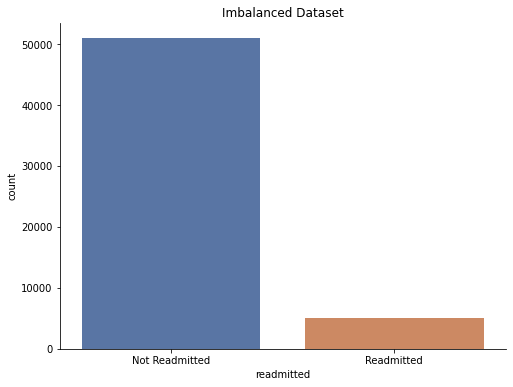

In [31]:
plt.figure(figsize=(8,6))
sns.countplot(y_train, palette='deep')
sns.despine()
plt.title('Imbalanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

In [32]:
# SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=123)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

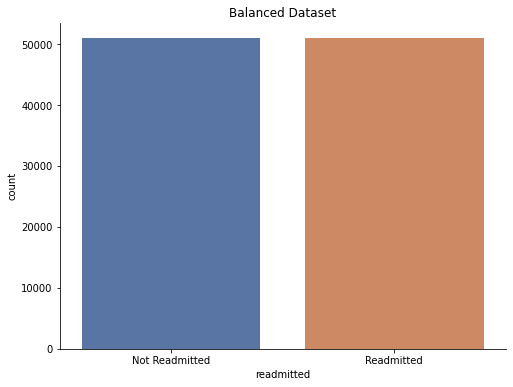

In [33]:
plt.figure(figsize=(8,6))
sns.countplot(y_train_res, palette='deep')
sns.despine()
plt.title('Balanced Dataset')
plt.xticks([0,1],['Not Readmitted', 'Readmitted'])
plt.show()

# Model Base Line

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

In [35]:
thresh = 0.5

### Logistic regression

In [36]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 123)
lr.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [37]:
y_train_preds = lr.predict_proba(X_train)[:,1]
y_valid_preds = lr.predict_proba(X_test)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Test:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.663
accuracy:0.910
recall:0.006
precision:0.408
specificity:0.999
prevalence:0.090
 
Test:
AUC:0.630
accuracy:0.910
recall:0.006
precision:0.500
specificity:0.999
prevalence:0.090
 


In [38]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 10, random_state = 123)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [39]:
#(Over fitting, grid search may help), do with cross validation logisiticregressioncv
y_train_preds = rf.predict_proba(X_train)[:,1]
y_valid_preds = rf.predict_proba(X_test)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Test:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_test,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.764
accuracy:0.910
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.090
 
Test:
AUC:0.633
accuracy:0.910
recall:0.000
precision:0.000
specificity:1.000
prevalence:0.090
 
